# **<a id="Content">HnM RecSys Notebook 9417</a>**

## **<a id="Content">Table of Contents</a>**
* [**<span>1. Imports</span>**](#Imports)  
* [**<span>2. Helper Functions/Decorators</span>**](#Helper-Functions)
* [**<span>5. LightGBM Model</span>**](#LightGBM-Model) 

## Imports

In [81]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import os
import re
import warnings
import scipy.sparse as sparse
from scipy.sparse.linalg import spsolve

## Helper-Functions

In [82]:
from datetime import datetime, timedelta

# only use last x weeks of transactions data since data is too large
def filter_transactions_last_x_weeks(transactions, x = 10):
    # Convert date strings to datetime objects
    transactions['t_dat'] = pd.to_datetime(transactions['t_dat'])

    # Calculate the date x weeks ago from the latest transaction date
    latest_date = transactions['t_dat'].max()
    cutoff_date = latest_date - timedelta(weeks=x)

    # Filter transactions to only include those in the last x weeks
    filtered_transactions = transactions.loc[transactions['t_dat'] >= cutoff_date].copy()

    return filtered_transactions

In [83]:
def filter_customers_and_articles(customers, articles, filtered_transactions):
    # Get unique customer and article IDs from filtered transactions
    customer_ids = filtered_transactions['customer_id'].unique()
    article_ids = filtered_transactions['article_id'].unique()

    # Filter customers and articles to only include those in filtered transactions
    customers_filtered = customers.loc[customers['customer_id'].isin(customer_ids)].copy()
    articles_filtered = articles.loc[articles['article_id'].isin(article_ids)].copy()

    return customers_filtered, articles_filtered

## LightGBM

A comparison of the top GBDT models today. LightGBM is the fastest to train.

|Feature|LightGBM|XGBoost|CatBoost|
|:----|:----|:----|:----|
|Categoricals|Supports categorical features via one-hot encoding|Supports categorical features via one-hot encoding|Automatically handles categorical features using embeddings|
|Speed|Very fast training and prediction|Fast training and prediction|Slower than LightGBM and XGBoost|
|Handling Bias|Handles unbalanced classes via 'is_unbalance'|Handles unbalanced classes via 'scale_pos_weight'|Automatically handles unbalanced classes|
|Handling NaNs|Handles NaN values natively|Requires manual handling of NaNs|Automatically handles NaN values using special category|
|Custom Loss|Supports custom loss functions|Supports custom loss functions|Supports custom loss functions|


To use LightGBM for a ranking problem, we treat this as a binary classification problem where the target variable is whether an item is relevant or not to the user.

Alternatively, we can use LightGBM's ranking API, which is designed for ranking problems. Instead of optimizing for accuracy, the ranking API optimizes for ranking metric MAP (MAP support deprecated however). 

### Feature Engineering

In [84]:
# LightGBM imports

from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.feature_selection import RFE
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import make_scorer
import lightgbm as lgb
from hyperopt import fmin, tpe, hp, STATUS_OK, Trials

In [85]:
import pickle

# open user_item_matrix_200
with open('user_item_matrix_200.pkl', 'rb') as f:
    user_item_matrix = pickle.load(f)

# open customer and articels incides map
with open('lightgbm/customer_id_indices_map.pkl', 'rb') as f:
    customer_id_indices_map = pickle.load(f)

with open('lightgbm/article_id_indices_map.pkl', 'rb') as f:
    article_id_indices_map = pickle.load(f)

# load df from pickle file for time-based split
with open('lightgbm/df.pkl', 'rb') as f:
    df = pickle.load(f)

# load final_df from pickle file for clean processing
with open('lightgbm/df_pos_neg.pkl', 'rb') as f:
    final_df = pickle.load(f)

In [86]:
final_df.columns

Index(['t_dat', 'price', 'sales_channel_1', 'sales_channel_2', 'quantity',
       'article_engagement_ratio', 'user_index', 'item_index', 'FN', 'Active',
       'club_member_status', 'fashion_news_frequency', 'age', 'time_diff_days',
       'user_purchase_quant', 'RFM_Score', 'product_type_no',
       'graphical_appearance_no', 'department_no', 'index_code', 'section_no',
       'age_diff', 'mean_purchase_age', 'max_purchase_age', 'min_purchase_age',
       'article_preference', 'item_purchase_frequency', 'item_avg_price_level',
       'target', 'year', 'month', 'day', 'garment_group_no_1001',
       'garment_group_no_1002', 'garment_group_no_1003',
       'garment_group_no_1005', 'garment_group_no_1006',
       'garment_group_no_1007', 'garment_group_no_1008',
       'garment_group_no_1009', 'garment_group_no_1010',
       'garment_group_no_1011', 'garment_group_no_1012',
       'garment_group_no_1013', 'garment_group_no_1014',
       'garment_group_no_1016', 'garment_group_no_1017',


### Model Training

In [87]:
# target encoding
# from category_encoders import TargetEncoder
# from sklearn.model_selection import KFold

# # Define columns to target encode
# cols_to_encode = ['department_no', 'product_type_no', 'section_no', 'graphical_appearance_no']

# # Define number of folds for cross-validation
# n_splits = 5

# # Create KFold object for cross-validation
# kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

# # Perform target encoding with cross-validation
# for col in cols_to_encode:
#     final_df[f'{col}_te'] = 0
#     te = TargetEncoder(cols=[col])
#     for train_idx, val_idx in kf.split(final_df):
#         te.fit(final_df.iloc[train_idx][[col]], final_df.iloc[train_idx]['target'])
#         final_df.loc[val_idx, f'{col}_te'] = te.transform(final_df.iloc[val_idx][[col]]).values.flatten()

In [88]:
# ---- memory optimizations -------------

# reference: https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65

# iterate through all the columns of a dataframe and reduce the int and float data types to the smallest possible size, ex. customer_id should not be reduced from int64 to a samller value as it would have collisions
import numpy as np
import pandas as pd

def reduce_mem_usage(df):
    """Iterate over all the columns of a DataFrame and modify the data type
    to reduce memory usage, handling ordered Categoricals"""
    
    # check the memory usage of the DataFrame
    start_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage of dataframe is {:.2f} MB".format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtype
        
        if col_type == 'category':
            if df[col].cat.ordered:
                # Convert ordered Categorical to an integer
                df[col] = df[col].cat.codes.astype('int16')
            else:
                # Convert unordered Categorical to a string
                df[col] = df[col].astype('str')
        
        elif col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min >= np.iinfo(np.int8).min and c_max <= np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min >= np.iinfo(np.int16).min and c_max <= np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min >= np.iinfo(np.int32).min and c_max <= np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min >= np.iinfo(np.int64).min and c_max <= np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min >= np.finfo(np.float16).min and c_max <= np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min >= np.finfo(np.float32).min and c_max <= np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    
    # check the memory usage after optimization
    end_mem = df.memory_usage().sum() / 1024**2
    print("Memory usage after optimization is: {:.2f} MB".format(end_mem))

    # calculate the percentage of the memory usage reduction
    mem_reduction = 100 * (start_mem - end_mem) / start_mem
    print("Memory usage decreased by {:.1f}%".format(mem_reduction))
    
    return df

In [89]:
# refrence: https://github.com/zhouyonglong/ml_metrics/blob/master/Python/ml_metrics/average_precision.py

from sklearn.metrics import make_scorer

def mapk(y_true, y_pred, k=12):
    """
    Computes the mean average precision at k.
    """
    return np.mean([apk(a, p, k) for a, p in zip(y_true, y_pred)])

def apk(actual, predicted, k=12):
    """
    Computes the average precision at k.
    """
    if len(predicted) > k:
        predicted = predicted[:k]

    score = 0.0
    num_hits = 0.0

    for i, p in enumerate(predicted):
        if p in actual and p not in predicted[:i]:
            num_hits += 1.0
            score += num_hits / (i + 1.0)

    if not actual:
        return 0.0

    return score / min(len(actual), k)

In [90]:
final_df.columns

Index(['t_dat', 'price', 'sales_channel_1', 'sales_channel_2', 'quantity',
       'article_engagement_ratio', 'user_index', 'item_index', 'FN', 'Active',
       'club_member_status', 'fashion_news_frequency', 'age', 'time_diff_days',
       'user_purchase_quant', 'RFM_Score', 'product_type_no',
       'graphical_appearance_no', 'department_no', 'index_code', 'section_no',
       'age_diff', 'mean_purchase_age', 'max_purchase_age', 'min_purchase_age',
       'article_preference', 'item_purchase_frequency', 'item_avg_price_level',
       'target', 'year', 'month', 'day', 'garment_group_no_1001',
       'garment_group_no_1002', 'garment_group_no_1003',
       'garment_group_no_1005', 'garment_group_no_1006',
       'garment_group_no_1007', 'garment_group_no_1008',
       'garment_group_no_1009', 'garment_group_no_1010',
       'garment_group_no_1011', 'garment_group_no_1012',
       'garment_group_no_1013', 'garment_group_no_1014',
       'garment_group_no_1016', 'garment_group_no_1017',


In [91]:
def time_based_train_test_split(final_df, test_size=0.2):

    # Sort dataframe by date in ascending order
    final_df = final_df.sort_values(by='t_dat')

    # Calculate cutoff index
    cutoff_index = int(len(final_df) * (1-test_size))

    # Create train and test dataframes
    train_df = final_df[:cutoff_index]
    test_df = final_df[cutoff_index:]

    # Drop date column from train and test dataframes
    train_df = train_df.drop('t_dat', axis=1)
    test_df = test_df.drop('t_dat', axis=1)

    # split train_df into X_train and y_train
    X_train = train_df.drop('target', axis=1)
    y_train = train_df['target']

    # split test_df into X_test and y_test
    X_test = test_df.drop('target', axis=1)
    y_test = test_df['target']

    return X_train, X_test, y_train, y_test

In [92]:
# 80/20 time-based split to curb data leakage
final_df = final_df.drop('index_code', axis=1)
final_df = final_df.drop(['day', 'month', 'year'], axis=1)
# drop the sales_chanel_id columns since they're not useful (from eda)
final_df = final_df.drop('sales_channel_1', axis=1)
final_df = final_df.drop('sales_channel_2', axis=1)
X_train, X_test, y_train, y_test = time_based_train_test_split(final_df, test_size=0.2)
# final_df_top_50 = final_df_top_50.drop('date', axis=1)
from sklearn.model_selection import train_test_split

# X_train, X_test, y_train, y_test = train_test_split(final_df.drop(['target'], axis=1), final_df['target'], test_size=0.2, random_state=42, stratify=final_df['target'])

# drop the date column from X_train, X_test
# X_train = X_train.drop('t_dat', axis=1)
# X_test = X_test.drop('t_dat', axis=1)

# redcue memory usage
X_train = reduce_mem_usage(X_train)
X_test = reduce_mem_usage(X_test)
y_train = y_train.astype(float)
y_test = y_test.astype(float)

# print the shape of X_train, X_test, y_train, y_test
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

Memory usage of dataframe is 27.67 MB
Memory usage after optimization is: 18.92 MB
Memory usage decreased by 31.6%
Memory usage of dataframe is 6.92 MB
Memory usage after optimization is: 4.73 MB
Memory usage decreased by 31.6%
(187194, 50)
(46799, 50)
(187194,)
(46799,)


In [93]:
import lightgbm as lgb
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import ndcg_score, average_precision_score
from sklearn.feature_selection import RFECV
import joblib
from sklearn.metrics import get_scorer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

In [27]:
# import lightgbm as lgb
# from sklearn.model_selection import GridSearchCV

# # define the parameter grid
# param_grid = {
#     'n_estimators': [500, 1000, 2000],
#     'num_leaves': [32, 64, 128],
#     'learning_rate': [0.001, 0.01, 0.1],
#     'lambda_l1': [0.0, 0.1, 0.5],
#     'lambda_l2': [0.0, 0.1, 0.5]
# }

# # define the classifier
# classifier = lgb.LGBMClassifier(objective='binary', boosting_type='dart', importance_type='gain', verbose=10)

# # define the GridSearchCV object
# grid_search = GridSearchCV(
#     estimator=classifier,
#     param_grid=param_grid,
#     scoring='roc_auc',  # use AUC as the scoring metric
#     cv=5,  # use 5-fold cross-validation
#     n_jobs=-1,  # use all available cores
#     verbose=10
# )

# # fit the GridSearchCV object to the training data
# grid_search.fit(X_train, y_train)

# # print the best hyperparameters and the corresponding AUC score
# print(f"Best hyperparameters: {grid_search.best_params_}")
# print(f"Best AUC score: {grid_search.best_score_}")

In [28]:
# Extract the best model from the grid search
# best_model = grid_search.best_estimator_

# # Evaluate the best model on the training set
# y_train_pred = best_model.predict_proba(X_train)[:, 1]
# train_auc = roc_auc_score(y_train, y_train_pred)
# print(f"Training AUC: {train_auc:.4f}")

# # Evaluate the best model on the test set
# y_test_pred = best_model.predict_proba(X_test)[:, 1]
# test_auc = roc_auc_score(y_test, y_test_pred)
# print(f"Test AUC: {test_auc:.4f}")

In [94]:
classifier = lgb.LGBMClassifier(
    objective="binary",
    metric="auc",
    boosting_type="dart",
    n_estimators=1000, # increase the number of trees
    importance_type='gain', # normalized gain to compare different models
    verbose=10, 
    lambda_l2=0.5,
    learning_rate=0.01, # learning rate
)

# train and evaluate using auc
classifier.fit(X_train, y_train,
    eval_set=[(X_test, y_test)],
    eval_metric='auc',
    early_stopping_rounds=50,
    verbose=10
)

C:\Users\mmdoh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightgbm\sklearn.py:726: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
C:\Users\mmdoh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Info] Number of positive: 126067, number of negative: 61127
[LightGBM] [Debug] Dataset::GetMultiBinFromAllFeatures: sparse rate 0.054227
[LightGBM] [Debug] init for col-wise cost 0.000008 seconds, init for row-wise cost 0.007939 seconds
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003311 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Debug] Using Dense Multi-Val Bin
[LightGBM] [Info] Total Bins 2547
[LightGBM] [Info] Number of data points in the train set: 187194, number of used features: 48
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Info] [binary:BoostFromSc

C:\Users\mmdoh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightgbm\callback.py:223: UserWarning: Early stopping is not available in dart mode
  _log_warning('Early stopping is not available in dart mode')


[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[30]	valid_0's auc: 0.552753
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 12
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 11
[40]	valid_0's auc: 0.55289
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 10
[LightGBM] [Debug] Trained a tree with leaves = 31 and depth = 13
[LightGBM] [Debug] 

LGBMClassifier(boosting_type='dart', importance_type='gain', lambda_l2=0.5,
               learning_rate=0.01, metric='auc', n_estimators=1000,
               objective='binary', verbose=10)

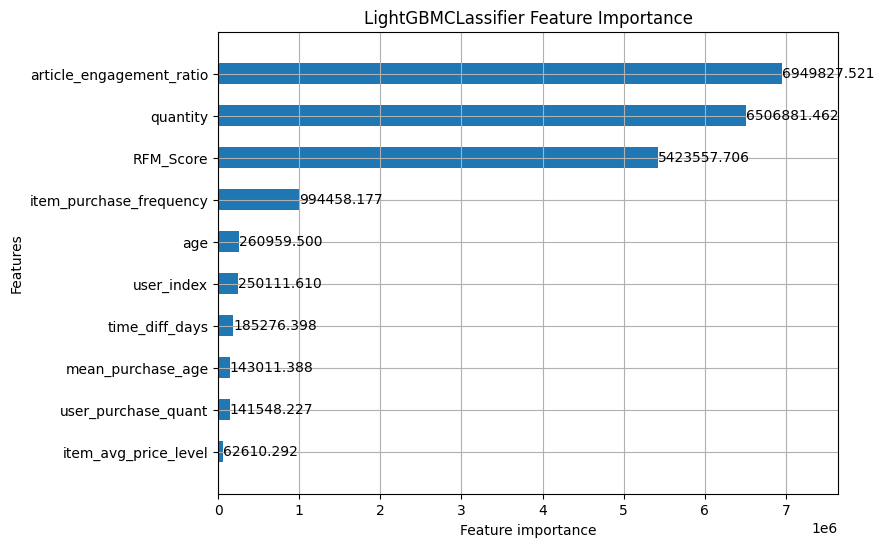

In [95]:
# Plot feature importance scores
fig, ax = plt.subplots(figsize=(8, 6))
lgb.plot_importance(classifier, max_num_features=10, height=0.5, ax=ax)
plt.title('LightGBMCLassifier Feature Importance')
plt.show()

In [96]:
# maximize map@12 using dart boosting
ranker = lgb.LGBMRanker(
    objective="lambdarank",
    metric="map",
    eval_at=12,
    boosting_type="dart",
    n_estimators=20, # decrease the number of trees
    importance_type='gain', # normalized gain to compare different models
    verbose=1, 
    learning_rate=0.005, # decrease the learning rate
    lambda_l2 = 0.5
)

In [97]:
# train and eval usin map@12
train_baskets = X_train.groupby(['user_index'])['item_index'].count().values
test_baskets = X_test.groupby(['user_index'])['item_index'].count().values

ranker = ranker.fit(X_train, y_train,
    group=train_baskets,
    eval_set=[(X_test, y_test)],
    eval_group=[test_baskets],
    eval_metric='map',
    eval_at=12,
    verbose=1
)

C:\Users\mmdoh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightgbm\sklearn.py:621: UserWarning: Found 'eval_at' in params. Will use it instead of 'eval_at' argument
  _log_warning(f"Found '{alias}' in params. Will use it instead of 'eval_at' argument")
C:\Users\mmdoh\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\lightgbm\sklearn.py:736: UserWarning: 'verbose' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose' argument is deprecated and will be removed in a future release of LightGBM. "


[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Info] Total groups: 200, total data: 187194
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002869 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2547
[LightGBM] [Info] Number of data points in the train set: 187194, number of used features: 48
[LightGBM] [Warning] lambda_l2 is set=0.5, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.5
[LightGBM] [Info] Total groups: 85, total data: 46799
[1]	valid_0's map@12: 0.303108
[2]	valid_0's map@12: 0.388232
[3]	valid_0's map@12: 0.400315
[4]	valid_0's map@12: 0.405634
[5]	valid_0's map@12: 0.403421
[6]	valid_0's map@12: 0.404109
[7]	valid_0's map@12: 0.404439
[8]	

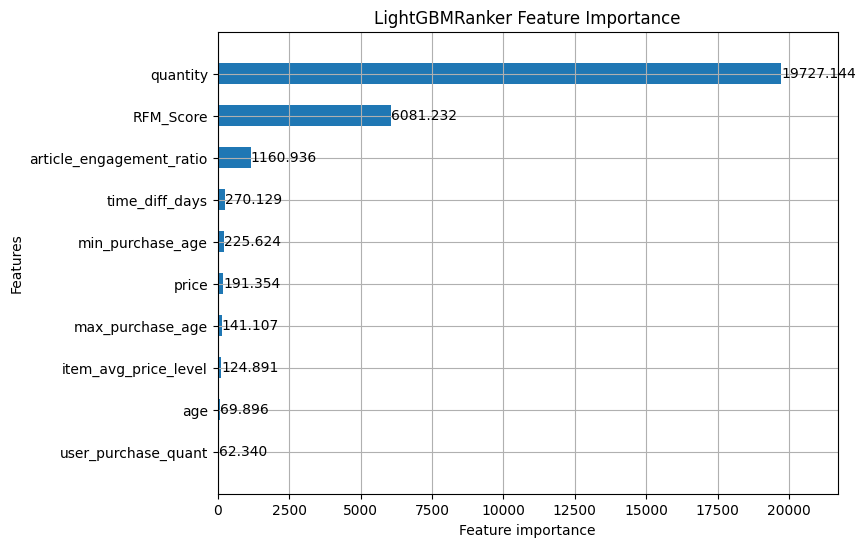

In [98]:
# Plot feature importance scores
fig, ax = plt.subplots(figsize=(8, 6))
lgb.plot_importance(ranker, max_num_features=10, height=0.5, ax=ax)
plt.title('LightGBMRanker Feature Importance')
plt.show()

Once the model is trained, it can be used to predict the probability of purchase for new user-product pairs, which can be used to generate recommendations for users.

After training the model, we can then get the probability that each user is likely to purchase an item from a candidate set of items. We can then sort these by descending probability to get the top 12 products as done below. <br>

A heuristic apparoach that we use to enhance LighGBM predictions here: <br>
1. Get a candidate set of top 500 most popular articles (by total purchase quanitity). <br>
2. Include the customer's predicitons to this set. <br>
3. Use lightGBM to predict the probability of purchases, and get the top 12. <br>

In [99]:
# dictionary 'user_products' that maps each user ID to a list of products they've purchased from the user-item matrix

user_products = {}
for user_idx in range(user_item_matrix.shape[0]):
    purchased_items = list(np.where(user_item_matrix[user_idx, :].toarray()[0] == 1)[0])
    user_products[user_idx] = purchased_items

In [100]:
# returns set of most pupular products in the catalog

def select_popular_products(df, n_products=500):
    # Group the dataframe by user and product and sum the quantity for each group
    product_quantities = df.groupby(['user_index', 'item_index'])['quantity'].sum()
    # Sort the products by quantity in descending order and select the top n_products
    popular_products = product_quantities.groupby('item_index').sum().sort_values(ascending=False).index.tolist()[:n_products]
    # return only the unique item_index values
    return list(set(popular_products))

In [101]:
# Generate candidate products for each user
# This can be done using a combination of popular products and user purchase history

popular_products = select_popular_products(final_df, 500)
print(len(popular_products))
# print first 10 popular products
print(popular_products[:20])

user_candidates = {}
for user_id in user_products:
    
    # Add user purchase history to candidate list
    user_history = user_products[user_id]
    popular_products_set = set(popular_products)
    user_history_set = set(user_history)
    candidate_products = list(popular_products_set - user_history_set)
    
    # Store candidate products (dataframes) for this user
    user_articles = final_df[final_df['item_index'].isin(candidate_products)]
    user_article_info = user_articles.groupby('item_index').first().reset_index()
    user_article_info = user_article_info.drop(['t_dat', 'target'], axis=1)
    user_candidates[user_id] = user_article_info

500
[4096, 0, 28674, 28675, 28676, 7, 6154, 18443, 30734, 14352, 14354, 4116, 6171, 24604, 28704, 45, 16432, 49, 16433, 18481]


In [102]:
# check where columns of X_test and user_candidates[0] dont match
for col in user_candidates[0].columns:
    if col not in X_test.columns:
        print(col)

In [103]:
for user_id in range(user_item_matrix.shape[0]):
    user_candidate_pool = user_candidates[user_id]
    item_probs = classifier.predict_proba(user_candidate_pool)
    top_items = user_candidate_pool.iloc[np.argsort(item_probs[:, 1])[::-1][:12]]
    print(f"Top recommended items for user {user_id}:")
    print(top_items['item_index'].values)

Top recommended items for user 0:
[ 3266 25458 26071 18831  4397 11137 25754 25604 11105 27403  4818 19795]
Top recommended items for user 1:
[14967  3266 26080  4397 21757  4116  4096 10209 10617 26990  4033  3819]
Top recommended items for user 2:
[36612 11950 11645 24998 24935 11908 24721 24604 24513 12010 14165 12202]
Top recommended items for user 3:
[15530  4397  5166 26071 26079 26080  4954 21757  4818 11105 11137 11210]
Top recommended items for user 4:
[36612 22787  6600  7326  8274  8582  9109 22822 22820  9282  9388 10684]
Top recommended items for user 5:
[25458 24178 24604 24513  4818 12643  4954 24271 12202 23865 26990  5166]
Top recommended items for user 6:
[15530 28412 26079 26080  5182  5166  4954 21970  4818 21757 11105 26990]
Top recommended items for user 7:
[21970 10686 12010 11950 11908 11645 11280 11210 11137 26990 36612 11105]
Top recommended items for user 8:
[14967 25754 21970 26071 26079 26080 21757  4397 10617  4116  4096 10684]
Top recommended items for us

In [104]:
preds = []
for user_id in range(user_item_matrix.shape[0]):
    user_candidate_pool = user_candidates[user_id]
    item_probs = ranker.predict(user_candidate_pool)
    top_items = user_candidate_pool.iloc[item_probs.argsort()[::-1][:12]]
    preds.append(top_items['item_index'].values)
    print(f"Top recommended items for user {user_id}:")
    print(top_items['item_index'].values)

Top recommended items for user 0:
[25458 23865  4818 17231 12202  5166  5182 24271 24178 12010 11645  5233]
Top recommended items for user 1:
[ 4096  9282  9388 25458 17231 12643  4397 25097 21117 24513  4818 24998]
Top recommended items for user 2:
[36612 11137 25458 21117  3819 25604 25754  9109  9282  9388 26071 26079]
Top recommended items for user 3:
[10686  3186 26079 26080  4096  4033  6600  3819 18072 22822 22820 22787]
Top recommended items for user 4:
[36612  7326  6154 14596 22822 22820 22787  6600 22707 22364 21970 23646]
Top recommended items for user 5:
[14035 24721 24513  4397 24271 11950  4818 24178 23865 11908  4954  5166]
Top recommended items for user 6:
[14608  5182 25604  4818 17231 25458  4954  5166 25097 16646  5233 24998]
Top recommended items for user 7:
[ 6154 22364 23646  5852 14948  6600 22822 22787  7326 22707  8274  4033]
Top recommended items for user 8:
[ 6154 20605  5233 23646  5852 22822 22820 22787 22707  6600 22364 21970]
Top recommended items for us

In [105]:
# # customer_id evaluation 
# customer_test = 5876564334685097984 #user_index 150

# find this key in custimer_id_indices_map and print the value
print(customer_id_indices_map[5854009424779598107])

150


In [106]:
# get all the item_index purchased by the customer with user_index 150 from final_df wehre target is 1
# and print random 50 products
recent_purchase_history = final_df[(final_df['user_index'] == 150) & (final_df['target'] == 1)]['item_index'].sample(20)

In [107]:
# given the reent purchase hisotry values, get the corresponding keys from article_id_indices_map and print the values


# find the keys in article_id_indices_map that match the values in recent_purchase_history and print the keys
# assuming that article_id_indices_map is a dictionary that maps article IDs to indices
# and recent_purchase_history is a list of article IDs
# find the keys in article_id_indices_map that match the values in recent_purchase_history and print the keys

rec_purchase_list = []
for article_id in recent_purchase_history:
    matching_keys = [f"0{str(k)}" for k, v in article_id_indices_map.items() if v == article_id]
    if matching_keys:
        rec_purchase_list.extend(matching_keys)
print(f"Matching keys for recent purchase history: {', '.join(rec_purchase_list)}")

Matching keys for recent purchase history: 0706016028, 0801309001, 0864216004, 0863646001, 0728197001, 0718716003, 0828934001, 0723799001, 0680262006, 0766654001, 0763273001, 0695723001, 0786176001, 0861847004, 0796245001, 0708175002, 0790057001, 0853545002, 0160442010, 0743594005


In [108]:
# import articles.csv
articles_og = pd.read_csv('articles.csv')

In [109]:
# get the article names for the recent purchase history
# get the product name for each matching article ID
prod_names = []
for article_id in rec_purchase_list:
    idx = article_id_indices_map[int(article_id)]
    # get the product name from the articles dataframe for that index
    prod_name = articles_og.loc[idx, 'prod_name']
    prod_names.append(prod_name)
    print(f"Product names for article ID {article_id}: {prod_name}\n")

Product names for article ID 0706016028: V-NECK SS BASIC FIT FANCY

Product names for article ID 0801309001: Laura sneaker

Product names for article ID 0864216004: Athena shopper

Product names for article ID 0863646001: ME KIDS LOLA SKIRT 2

Product names for article ID 0728197001: Saturn balconettes

Product names for article ID 0718716003: Ocean casual crew

Product names for article ID 0828934001: SHANTI Swimsuit SG

Product names for article ID 0723799001: Pierra sandal

Product names for article ID 0680262006: Dahlia dress

Product names for article ID 0766654001: Anna Price Sandal BG

Product names for article ID 0763273001: Kazimir cashmere polo

Product names for article ID 0695723001: Mustang shorts

Product names for article ID 0786176001: Badger price

Product names for article ID 0861847004: Sally 2-Pack Top

Product names for article ID 0796245001: W Teres EQ

Product names for article ID 0708175002: Illaria

Product names for article ID 0790057001: SS small dot

Product

In [110]:
prod_names

['V-NECK SS BASIC FIT FANCY',
 'Laura sneaker',
 'Athena shopper',
 'ME KIDS LOLA SKIRT 2',
 'Saturn balconettes',
 'Ocean casual crew',
 'SHANTI Swimsuit SG',
 'Pierra sandal',
 'Dahlia dress',
 'Anna Price Sandal BG',
 'Kazimir cashmere polo',
 'Mustang shorts',
 'Badger price',
 'Sally 2-Pack Top',
 'W Teres EQ',
 'Illaria',
 'SS small dot',
 'London bucket shopper',
 'Tanktop body white 3PACK',
 'Class Landar mixpack']

In [111]:
top_recc_clf = [18481, 14999, 20131, 21914, 21289, 967, 8582, 11552, 22867, 22611, 6863, 18847]
top_recc_rank = [22715, 5744, 17741, 17740, 27324, 27333, 23640, 20082, 17298, 20131, 20300, 27821]

In [114]:
clf_recco_list = []
for article_id in top_recc_clf:
    matching_keys = [f"0{str(k)}" for k, v in article_id_indices_map.items() if v == article_id]
    if matching_keys:
        clf_recco_list.extend(matching_keys)
print(f"Matching keys for recent purchase history: {', '.join(clf_recco_list)}")

Matching keys for recent purchase history: 0719233001, 0695632101, 0733267001, 0745843002, 0740938001, 0446224002, 0637515010, 0668537001, 0753061004, 0751542002, 0618800007, 0721481001


In [115]:
rank_recco_list = []
for article_id in top_recc_rank:
    matching_keys = [f"0{str(k)}" for k, v in article_id_indices_map.items() if v == article_id]
    if matching_keys:
        rank_recco_list.extend(matching_keys)
print(f"Matching keys for recent purchase history: {', '.join(rank_recco_list)}")

Matching keys for recent purchase history: 0752020001, 0599580017, 0714790017, 0714790008, 0790006002, 0790096001, 0758084002, 0733094001, 0711521004, 0733267001, 0734287001, 0795440003


In [116]:
clf_prod_names = []
for article_id in clf_recco_list:
    idx = article_id_indices_map[int(article_id)]
    # get the product name from the articles dataframe for that index
    prod_name = articles_og.loc[idx, 'prod_name']
    clf_prod_names.append(prod_name)
    print(f"Product names for article ID {article_id}: {prod_name}\n")

Product names for article ID 0719233001: TP Fries & Ties shirt

Product names for article ID 0695632101: Drake sweatpants

Product names for article ID 0733267001: Bella dress

Product names for article ID 0745843002: Oliver Multi BackPack

Product names for article ID 0740938001: PANAREA

Product names for article ID 0446224002: HONEY 2-P LEGGINGS

Product names for article ID 0637515010: STELLAR tights

Product names for article ID 0668537001: Marissa

Product names for article ID 0753061004: Philli flower embroideryCSP

Product names for article ID 0751542002: Kurt sunglasses

Product names for article ID 0618800007: MIA FANCY

Product names for article ID 0721481001: Lorne block hood



In [117]:
rank_prod_names = []
for article_id in rank_recco_list:
    idx = article_id_indices_map[int(article_id)]
    # get the product name from the articles dataframe for that index
    prod_name = articles_og.loc[idx, 'prod_name']
    rank_prod_names.append(prod_name)
    print(f"Product names for article ID {article_id}: {prod_name}\n")

Product names for article ID 0752020001: Hudson shorts

Product names for article ID 0599580017: Sport sock 5-p anklesock B (1)

Product names for article ID 0714790017: SULLIVAN CREWNECK (1)

Product names for article ID 0714790008: SULLIVAN CREWNECK (1)

Product names for article ID 0790006002: Marie 7-p. ankle sock SG

Product names for article ID 0790096001: FILIPPA PRICE TANK VP 5

Product names for article ID 0758084002: Super Skinny Medieval

Product names for article ID 0733094001: WALES

Product names for article ID 0711521004: Nancy Oversized Hoodie

Product names for article ID 0733267001: Bella dress

Product names for article ID 0734287001: Joe Jeans

Product names for article ID 0795440003: Madison destroy



In [118]:
clf_prod_names

['TP Fries & Ties shirt',
 'Drake sweatpants',
 'Bella dress',
 'Oliver Multi BackPack',
 'PANAREA',
 'HONEY 2-P LEGGINGS',
 'STELLAR tights',
 'Marissa',
 'Philli flower embroideryCSP',
 'Kurt sunglasses',
 'MIA FANCY',
 'Lorne block hood']

In [119]:
rank_prod_names

['Hudson shorts',
 'Sport sock 5-p anklesock B (1)',
 'SULLIVAN CREWNECK (1)',
 'SULLIVAN CREWNECK (1)',
 'Marie 7-p. ankle sock SG',
 'FILIPPA PRICE TANK VP 5',
 'Super Skinny Medieval',
 'WALES',
 'Nancy Oversized Hoodie',
 'Bella dress',
 'Joe Jeans',
 'Madison destroy']